In [20]:
import pandas as pd
import numpy as np
import geopandas as gp
from unidecode import unidecode
from sklearn.cluster import AgglomerativeClustering as agglcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Argentinian provinces that make up 85% of its wheat production
relevant_areas = ['Buenos Aires', 'Córdoba', 'Entre Ríos', 'La Pampa', 'Santa Fe']

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Read Shapefiles 

- gdf_adm1: state level
- gdf_adm2: municipality level

In [21]:
# Read ADM1 shapefiles and filter by relevant provinces
gdf_adm1_raw = gp.read_file("data/shapefile/arg_admbnda_adm1_unhcr2017.shp")
gdf_adm1 = gdf_adm1_raw.loc[gdf_adm1_raw["ADM1_ES"].isin(relevant_areas), ["ADM1_ES", "geometry"]].reset_index(drop=True)
gdf_adm1 = gdf_adm1.to_crs("EPSG:4326")
gdf_adm1_raw = gdf_adm1_raw.to_crs("EPSG:4326")

# Read ADM2 shapefiles and filter by relevant provinces
gdf_adm2 = gp.read_file("data/shapefile/arg_admbnda_adm2_unhcr2017.shp")
gdf_adm2 = gdf_adm2.sjoin(gdf_adm1, how="inner", predicate="intersects")
gdf_adm2["ADM2_ES"] = gdf_adm2["ADM2_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["ADM1_ES_left"] = gdf_adm2["ADM1_ES_left"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["name"] = gdf_adm2["ADM1_ES_left"] + " " + gdf_adm2["ADM2_ES"]
gdf_adm2 = gdf_adm2[["name", "geometry"]].reset_index(drop=True)

## 2. Read historical wheat data

- on province level 
- merge with gdf_adm2 to obtain polygon shape for each region

In [22]:
wheat = pd.read_csv("data/crop/province_yield_with_trend.csv", encoding="latin-1")
wheat["province"] = wheat["province"].str.lower().apply(lambda x: unidecode(x))
wheat["municipality"] = wheat["municipality"].str.lower().apply(lambda x: unidecode(x))
wheat["name"] = wheat["province"] + " " + wheat["municipality"]

# Merge with shapefiles to filter relevant departments
wheat = wheat.merge(gdf_adm2[["geometry", "name"]], on="name", how="left").dropna().drop_duplicates()

wheat.head()

,year,province,municipality,harvested area [ha],production [t],yield [kg/ha],name,geometry
0,1969,buenos aires,25 de mayo,42000,71400,1700,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
1,1970,buenos aires,25 de mayo,36000,54000,1500,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
2,1971,buenos aires,25 de mayo,30000,39000,1300,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
3,1972,buenos aires,25 de mayo,41000,73600,1795,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
4,1973,buenos aires,25 de mayo,6000,9000,1500,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."


#### Plot map

- color municipalities that are part of this study
- because they are part of the five states that contribute mainly to argentinian wheat production..
- ..and because they have a complete yield time series

<Axes: >

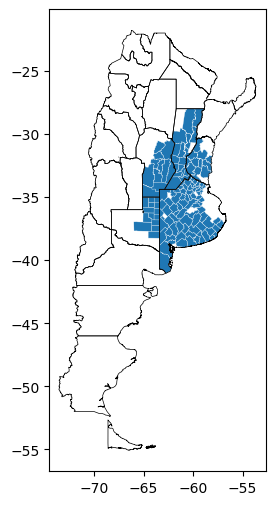

In [23]:
name_filter = wheat["name"].unique().tolist()
gdf_adm2_temp = gdf_adm2.copy()

gdf_adm2_temp["complete_yield_series"] = gdf_adm2_temp["name"].apply(lambda x: "yes" if x in name_filter else "no")
gdf_adm2_temp = gdf_adm2_temp.loc[gdf_adm2_temp["complete_yield_series"] == "yes"].reset_index(drop=True)

base = gdf_adm2_temp.plot(figsize=(6,6), column="complete_yield_series", edgecolor="white", linewidth=.2)
gdf_adm1_raw.plot(ax=base,  color="#FF000000", edgecolor="black", linewidth=0.5)

## 3. Filter ERA by coordinates

In [24]:
era = pd.read_csv("data/ERA/era_complete.csv")
era = gp.GeoDataFrame(era, geometry=gp.points_from_xy(era["lon"], era["lat"], crs="EPSG:4326"))
era_coordinates = era.groupby(["lat", "lon"]).agg({"geometry":"first"}).reset_index()
era_coordinates = gp.GeoDataFrame(era_coordinates, geometry="geometry", crs="EPSG:4326")
era_coordinates = gp.sjoin(era_coordinates, gdf_adm2_temp).reset_index(drop=True)[["lat", "lon", "geometry", "name"]]
era = era_coordinates[["lat", "lon", "name"]].merge(era, left_on=["lat", "lon"], right_on=["lat", "lon"], how="left")
era.head()
#era_filtered = era.loc[era["month"].between(5,11)]

,lat,lon,name,time,rain,tmean,month,year,geometry
0,-40.9,-62.8,buenos aires patagones,1968-01-01 00:00:00,0.000623,20.971094,1,1968,POINT (-62.80000 -40.90000)
1,-40.9,-62.8,buenos aires patagones,1968-02-01 00:00:00,0.000731,21.416162,2,1968,POINT (-62.80000 -40.90000)
2,-40.9,-62.8,buenos aires patagones,1968-03-01 00:00:00,0.001365,17.787500,3,1968,POINT (-62.80000 -40.90000)
3,-40.9,-62.8,buenos aires patagones,1968-04-01 00:00:00,0.000269,14.364648,4,1968,POINT (-62.80000 -40.90000)
4,-40.9,-62.8,buenos aires patagones,1968-05-01 00:00:00,0.000249,12.334131,5,1968,POINT (-62.80000 -40.90000)


<Axes: >

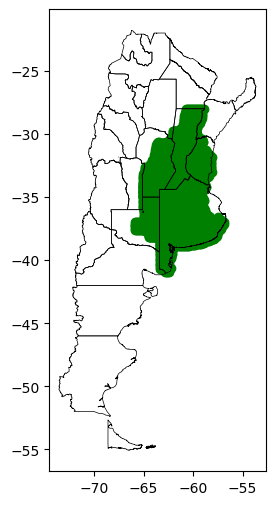

In [25]:
base = era_coordinates.plot(figsize=(6,6), color="green")
gdf_adm1_raw.plot(ax=base,  color="#FF000000", edgecolor="black", linewidth=0.5)

### 4. Determine relevant locations

- averaging tmean and rain across all Argentina is not ideal (area is huge, signal gets lost)
- it is planned to determine 2-4 climate clusters and use the centroids as the locations for the ERA data
- to prevent overfitting we build cluster using data from 1969-1992

In [26]:
wheat.head()

,year,province,municipality,harvested area [ha],production [t],yield [kg/ha],name,geometry
0,1969,buenos aires,25 de mayo,42000,71400,1700,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
1,1970,buenos aires,25 de mayo,36000,54000,1500,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
2,1971,buenos aires,25 de mayo,30000,39000,1300,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
3,1972,buenos aires,25 de mayo,41000,73600,1795,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."
4,1973,buenos aires,25 de mayo,6000,9000,1500,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0..."


In [27]:
li = []
for area in wheat["name"].unique():
    wheat_area = wheat.loc[(wheat["year"] < 1993) & (wheat["name"] == area), ["year", "yield [kg/ha]", "name", "geometry"]]
    #year_range = wheat.loc[wheat["year"].isin(list(range(year-24, year))), ["year", "yield [kg/ha]"]]
    (slope, bias), (current_error,), *_ = np.polyfit(wheat_area["year"], wheat_area["yield [kg/ha]"], deg=1, full=True)
    wheat_area["yield detrended"] = wheat_area["yield [kg/ha]"] - (wheat_area["year"] * slope + bias)
    li.append(wheat_area)
wheat_filtered_detrended = pd.concat(li, axis=0, ignore_index=True)
wheat_filtered_detrended

,year,yield [kg/ha],name,geometry,yield detrended
0,1969,1700,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0...",401.923333
1,1970,1500,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0...",168.089420
2,1971,1300,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0...",-65.744493
3,1972,1795,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0...",395.421594
4,1973,1500,buenos aires 25 de mayo,"POLYGON Z ((-60.02052 -35.10801 0.00000, -60.0...",66.587681
...,...,...,...,...,...
3115,1988,1200,santa fe vera,"POLYGON Z ((-60.21674 -27.99943 0.00000, -59.8...",-403.075362
3116,1989,1500,santa fe vera,"POLYGON Z ((-60.21674 -27.99943 0.00000, -59.8...",-136.113188
3117,1990,2045,santa fe vera,"POLYGON Z ((-60.21674 -27.99943 0.00000, -59.8...",375.848986
3118,1991,1400,santa fe vera,"POLYGON Z ((-60.21674 -27.99943 0.00000, -59.8...",-302.188841


In [33]:
era.head()

,lat,lon,name,time,rain,tmean,month,year,geometry
0,-40.9,-62.8,buenos aires patagones,1968-01-01 00:00:00,0.000623,20.971094,1,1968,POINT (-62.80000 -40.90000)
1,-40.9,-62.8,buenos aires patagones,1968-02-01 00:00:00,0.000731,21.416162,2,1968,POINT (-62.80000 -40.90000)
2,-40.9,-62.8,buenos aires patagones,1968-03-01 00:00:00,0.001365,17.787500,3,1968,POINT (-62.80000 -40.90000)
3,-40.9,-62.8,buenos aires patagones,1968-04-01 00:00:00,0.000269,14.364648,4,1968,POINT (-62.80000 -40.90000)
4,-40.9,-62.8,buenos aires patagones,1968-05-01 00:00:00,0.000249,12.334131,5,1968,POINT (-62.80000 -40.90000)


In [39]:
era_filtered = (era
                .loc[(era["year"].astype(int) >= 1993) 
                     & (era["month"].between(8,11))
                     & (era["name"].isin(["buenos aires coronel dorrego", "buenos aires hipolito yrigoyen"]))]
                .reset_index(drop=True)
                .groupby(["name", "month", "year"])
                .agg({"rain":"mean", "tmean":"mean"}).reset_index())

In [40]:
era_filtered["year"].unique()

array([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], dtype=int64)

In [41]:
era_filtered.to_csv("data/era_filtered_locations.csv", index=False)

In [42]:
weather_features = era_filtered.pivot(index="year", columns=["month", "name"], values=["rain", "tmean"])

weather_features.columns = ["{}_{}_{}".format(s[0],s[1],s[2]) for s in weather_features.columns]

weather_features = weather_features.reset_index()
weather_features.head()

,year,rain_8_buenos aires coronel dorrego,rain_9_buenos aires coronel dorrego,rain_10_buenos aires coronel dorrego,rain_11_buenos aires coronel dorrego,rain_8_buenos aires hipolito yrigoyen,rain_9_buenos aires hipolito yrigoyen,rain_10_buenos aires hipolito yrigoyen,rain_11_buenos aires hipolito yrigoyen,tmean_8_buenos aires coronel dorrego,tmean_9_buenos aires coronel dorrego,tmean_10_buenos aires coronel dorrego,tmean_11_buenos aires coronel dorrego,tmean_8_buenos aires hipolito yrigoyen,tmean_9_buenos aires hipolito yrigoyen,tmean_10_buenos aires hipolito yrigoyen,tmean_11_buenos aires hipolito yrigoyen
0,1993,0.000204,0.000629,0.001886,0.002961,0.000622,0.002687,0.002157,0.005082,10.112333,11.635667,14.787833,16.469500,10.272308,11.610769,16.042308,17.662308
1,1994,0.001294,0.000819,0.001880,0.001744,0.002331,0.001586,0.002564,0.001845,9.102000,11.997500,13.506667,19.338333,9.853077,12.882308,14.715385,19.764615
2,1995,0.001060,0.000536,0.002009,0.003304,0.000590,0.001148,0.002388,0.004076,8.553833,11.863667,14.151667,18.022500,9.418462,13.288462,15.503846,19.739231
3,1996,0.003406,0.000632,0.003675,0.003039,0.001807,0.001189,0.003135,0.003330,11.398833,11.581000,15.138333,18.581000,12.302308,12.624615,16.642308,19.933846
4,1997,0.001251,0.001325,0.003286,0.002113,0.001689,0.001448,0.006382,0.004226,9.445500,10.045667,13.813500,16.640667,10.813077,11.807692,14.850000,17.690769


In [43]:
weather_features.to_csv("data/weather_features_era.csv", index=False)